In [1]:
!pwd

/notebook


In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import json, sys, os

path_to_be_add = '/notebook/personal/ksuchoi216/face-identification-model/'
if not path_to_be_add in sys.path:
  sys.path.insert(0, path_to_be_add)
  os.chdir(path_to_be_add)

print(f'System path as follows:')
for path in sys.path:
  print(f'    {path}')

def load_config():
  config_path = './configs/config_data_preparation.json'
  with open(config_path) as f:
    cfg = json.load(f)
  
  print(f'\nconfig file: {cfg}')
  
  return cfg
cfg = load_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System path as follows:
    /notebook/personal/ksuchoi216/face-identification-model/
    /notebook
    /root/.pyenv/versions/3.9.1/lib/python39.zip
    /root/.pyenv/versions/3.9.1/lib/python3.9
    /root/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload
    
    /root/.pyenv/versions/python39/lib/python3.9/site-packages

config file: {'data_source': './data/', 'folder_to_save': './data/photos_2m/', 'frame_count_limit': 300, 'frame_interval_for_sampling': 60, 'data': {'path_folder_for_saved_images': './data/photos_2m/', 'path_folder_for_saving_cropped_faces': './data/photos_cropped/', 'image_size': 500}}


# Images extracted from video(2m distance)

In [49]:
import cv2

cfg = load_config()
data_source = cfg['data_source']
folder_to_save = cfg['folder_to_save']
frame_count_limit = cfg['frame_count_limit']
frame_interval_for_sampling = cfg['frame_interval_for_sampling']

if not os.path.exists(folder_to_save):
  os.makedirs(folder_to_save)

user_names = ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi']
video_names = ['1', '2', '3', '4']

for user_name, video_name in zip(user_names, video_names):
  path_for_video = data_source + 'video/'+video_name + '.mp4'
  path_for_username_folder = folder_to_save + user_name+'/'
  print(f'{path_for_video} with {path_for_username_folder}')
  
  if not os.path.exists(path_for_username_folder):
    os.makedirs(path_for_username_folder)
    
  vc = cv2.VideoCapture(path_for_video)
  success, frame = vc.read()

  count = 0
  frame_count = 0

  while success:
    success, frame = vc.read()

    if frame_count == frame_count_limit:
      break

    count += 1
    if count%frame_interval_for_sampling == 0:
      path_for_save = path_for_username_folder + str(frame_count) + '.jpg'
      cv2.imwrite(path_for_save, frame)
      success, frame = vc.read()
      print(f'[{count}][{frame_count}]A image was saved at {path_for_save}')
      frame_count += 1




./data/video/1.mp4 with ./data/photos_2m/jhyoo/
[100][0]A image was saved at ./data/photos_2m/jhyoo/0.jpg
[200][1]A image was saved at ./data/photos_2m/jhyoo/1.jpg
[300][2]A image was saved at ./data/photos_2m/jhyoo/2.jpg
[400][3]A image was saved at ./data/photos_2m/jhyoo/3.jpg
[500][4]A image was saved at ./data/photos_2m/jhyoo/4.jpg
[600][5]A image was saved at ./data/photos_2m/jhyoo/5.jpg
[700][6]A image was saved at ./data/photos_2m/jhyoo/6.jpg
[800][7]A image was saved at ./data/photos_2m/jhyoo/7.jpg
[900][8]A image was saved at ./data/photos_2m/jhyoo/8.jpg
[1000][9]A image was saved at ./data/photos_2m/jhyoo/9.jpg
[1100][10]A image was saved at ./data/photos_2m/jhyoo/10.jpg
[1200][11]A image was saved at ./data/photos_2m/jhyoo/11.jpg
[1300][12]A image was saved at ./data/photos_2m/jhyoo/12.jpg
[1400][13]A image was saved at ./data/photos_2m/jhyoo/13.jpg
[1500][14]A image was saved at ./data/photos_2m/jhyoo/14.jpg
[1600][15]A image was saved at ./data/photos_2m/jhyoo/15.jpg
[1700

# Preprocessing


In [50]:
import torch
import torchvision
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
from external_lib import MTCNN, InceptionResnetV1
import warnings
warnings.filterwarnings("ignore")

print(MTCNN)

<class 'external_lib.facenet_pytorch.models.mtcnn.MTCNN'>


0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi


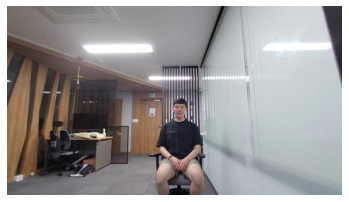

face shape: torch.Size([3, 500, 500]) / face prob: 0.9999232292175293


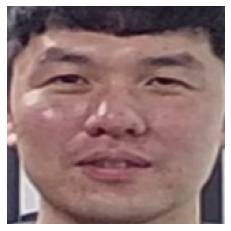

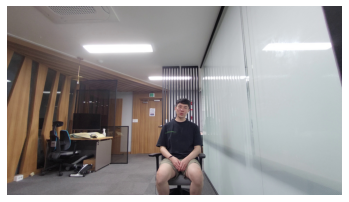

face shape: torch.Size([3, 500, 500]) / face prob: 0.999929666519165


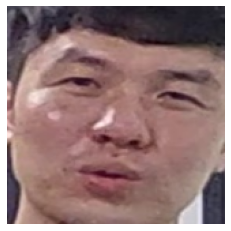

In [51]:
# initializing MTCNN and InceptionResnetV1 
image_size = 500
mtcnn = MTCNN(image_size=image_size, margin=0, keep_all=False, min_face_size=image_size*0.1) # keep_all=False
mtcnn_multi = MTCNN(image_size=image_size, margin=0, keep_all=True, min_face_size=image_size*0.1) # keep_all=True
mtcnn_show = MTCNN(select_largest=False, post_process=False)
resnet = InceptionResnetV1(pretrained='vggface2').eval()


dataset = datasets.ImageFolder(folder_to_save) # photos folder path 
idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of peoples from folder names

for i,c in idx_to_class.items():
    print(i,c)

def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn)

for i, (img, idx) in enumerate(loader):
    if i < 2:
        face, prob = mtcnn(img, return_prob=True)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print(f'face shape: {face.shape} / face prob: {prob}')
    
        face_test = mtcnn_show(img)
        plt.imshow(face_test.permute(1,2,0).int().numpy())
        plt.axis('off')
        plt.show()
    else:
        break


In [52]:
from datasets import DataPreparation

cfg=load_config()
dataPreparation = DataPreparation(cfg['data'])
dataPreparation.save_cropped_faces()

new folder was created in  ./data/photos_cropped/
Starting data load...
0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi
saved cropped face image in  ./data/photos_cropped/jhoh/1.png
saved cropped face image in  ./data/photos_cropped/jhoh/2.png
saved cropped face image in  ./data/photos_cropped/jhoh/3.png
saved cropped face image in  ./data/photos_cropped/jhoh/4.png
saved cropped face image in  ./data/photos_cropped/jhoh/5.png
saved cropped face image in  ./data/photos_cropped/jhoh/6.png
saved cropped face image in  ./data/photos_cropped/jhoh/7.png
saved cropped face image in  ./data/photos_cropped/jhoh/8.png
saved cropped face image in  ./data/photos_cropped/jhoh/9.png
saved cropped face image in  ./data/photos_cropped/jhoh/10.png
saved cropped face image in  ./data/photos_cropped/jhoh/11.png
saved cropped face image in  ./data/photos_cropped/jhoh/12.png
saved cropped face image in  ./data/photos_cropped/jhoh/13.png
saved cropped face image in  ./data/photos_cropped/jhoh/14.png
saved cropped face i